In [1]:
#!/usr/bin/env python
# coding: utf-8

import rosbag, os, matplotlib, pickle
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d
from qsrlib.qsrlib import QSRlib, QSRlib_Request_Message
from qsrlib_io.world_trace import Object_State, World_Trace
from qsrlib.qsrlib import QSR_QTC_BC_Simplified
import numpy as np
import pandas as pd
import datetime as dt

os.chdir("/home/loz/QTC_Trajectory_HMMs/from_bags/")

In [2]:
# In[2]:


lab_bags = [os.path.join(dp, f) for dp, dn, fn in os.walk(os.path.expanduser("~/QTC_Trajectory_HMMs/from_bags/HRSI_situation_QTC_rosbags")) for f in fn]

In [3]:
# In[60]:


r_positions = []
h_positions = []

r_state_seqs = []
h_state_seqs = []

qsrlib = QSRlib()

for bag_path in lab_bags:
    bag = rosbag.Bag(bag_path)
    
    r_xs = []
    r_ys = []
    
    r_state_seq = []
    for topic, msg, t in bag.read_messages(topics=['/robot5/control/odom']):
        t = t.to_sec()
        x = msg.pose.pose.position.x
        y = msg.pose.pose.position.y
        
        r_xs.append(x)
        r_ys.append(y)
        
        r_state_seq.append(Object_State(name="robot", timestamp=t, x=x, y=y))
    r_state_seqs.append(r_state_seq)
    
    h_xs = []
    h_ys = []
    
    h_state_seq = []
    for topic, msg, t in bag.read_messages(topics=['/robot5/people_tracker_filtered/positions']):
        t = t.to_sec()
        try:
            x = msg.poses[0].position.x
            y = msg.poses[0].position.y
            
            h_xs.append(x)
            h_ys.append(y)
            
            h_state_seq.append(Object_State(name="human", timestamp=t, x=x, y=y))
    
        except:
            pass
    h_state_seqs.append(h_state_seq)
    
    bag.close()
    r_positions.append([r_xs, r_ys])
    h_positions.append([h_xs, h_ys])


# In[61]:

In [4]:
# Test getting QTC_C sequence
bag_no = 0
quantisation_factor = 0.01

world = World_Trace()

h_x = [h_state_seqs[bag_no][i].x for i in range(len(h_state_seqs[bag_no]))]
h_y = [h_state_seqs[bag_no][i].y for i in range(len(h_state_seqs[bag_no]))]


r_x = [r_state_seqs[bag_no][i].x for i in range(len(r_state_seqs[bag_no]))]
r_y = [r_state_seqs[bag_no][i].y for i in range(len(r_state_seqs[bag_no]))]

In [5]:
# In[62]:


# Downsample state series' to 200kHz frequency
h_state_series = pd.DataFrame({"x": h_x, "y": h_y},
    index=[pd.to_datetime(h_state_seqs[bag_no][i].timestamp, unit="s") for i in range(len(h_state_seqs[bag_no]))])

h_state_series = h_state_series.resample("200ms").mean()

In [6]:
# In[63]:


r_state_series = pd.DataFrame({"x": r_x, "y": r_y},
    index=[pd.to_datetime(r_state_seqs[bag_no][i].timestamp, unit="s") for i in range(len(r_state_seqs[bag_no]))])

r_state_series = r_state_series.resample("200ms").mean()

In [7]:
# In[64]:


# Create world_trace state series from downsampled human position data
h_state_seq = []
for index, row in h_state_series.iterrows():
    x = row['x']
    y = row['y']
    t = (pd.to_datetime(index) - dt.datetime(1970,1,1)).total_seconds()
    
    h_state_seq.append(Object_State(name="human", timestamp=t, x=x, y=y))

In [8]:
# In[65]:


# Create world_trace state series from downsampled robot position data
r_state_seq = []
for index, row in r_state_series.iterrows():
    x = row['x']
    y = row['y']
    t = (pd.to_datetime(index) - dt.datetime(1970,1,1)).total_seconds()
    
    r_state_seq.append(Object_State(name="robot", timestamp=t, x=x, y=y))

In [9]:
# In[83]:


world.add_object_state_series(h_state_seq)
world.add_object_state_series(r_state_seq)

# make a QSRlib request message
dynamic_args = {"qtccs": {"no_collapse": True, "quantisation_factor": quantisation_factor,
                                        "validate": False, "qsrs_for": [("human", "robot")]}}

qsrlib_request_message = QSRlib_Request_Message(
    'qtccs', world, dynamic_args)

# request your QSRs
qsrlib_response_message = qsrlib.request_qsrs(req_msg=qsrlib_request_message)
qsrlib_response_message

In [10]:
# Get QSR at each timestamp
timestamps = qsrlib_response_message.qsrs.get_sorted_timestamps()
for t in timestamps:
    for val in qsrlib_response_message.qsrs.trace[t].qsrs.values():
        print(val.qsr['qtccs'].replace(",",""))

----
----
----
-0--
-0--
-+--
-+--
-+--
-+--
++--
++-0
++-0
++-+
++-+
++-+
-+++
+++-
0+--
++--
++--
-+--


In [11]:
# In[9]:
bag_path = lab_bags[bag_no]
bag_path[67:].replace("/", "_")[:-4]

'pb_l_2'

# Build dict of bags and their QTC_C sequences

pb_l_25


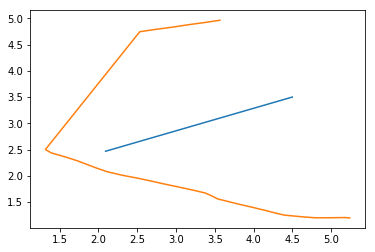


pb_l_26


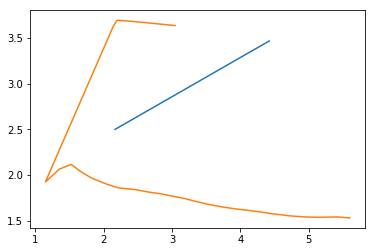


pb_l_23


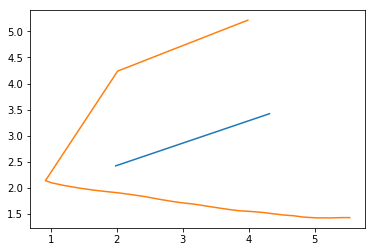


pb_l_30


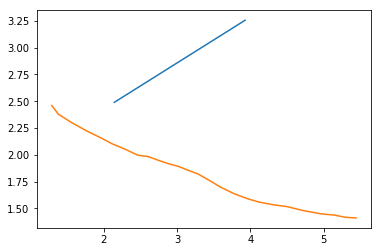


pb_l_1


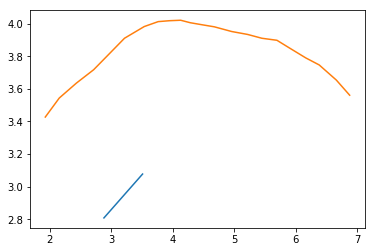


pb_r_2


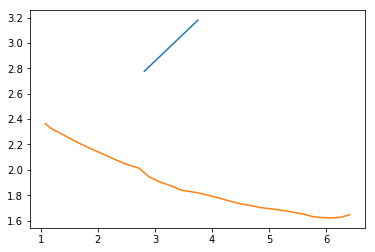

KeyboardInterrupt: 

In [15]:
quantisation_factor = 0.01
qtc_seqs = {}

for bag_no in range(30, len(lab_bags)):
    qtc_seq = []
    sit_code = lab_bags[bag_no][67:].replace("/", "_")[:-4]
    initial_bag_nos = range(1,6)
    
#     if int(sit_code.split("_")[-1]) not in initial_bag_nos:    
    print(sit_code)

    world = World_Trace()

    h_x = [h_state_seqs[bag_no][i].x for i in range(len(h_state_seqs[bag_no]))]
    h_y = [h_state_seqs[bag_no][i].y for i in range(len(h_state_seqs[bag_no]))]


    r_x = [r_state_seqs[bag_no][i].x for i in range(len(r_state_seqs[bag_no]))]
    r_y = [r_state_seqs[bag_no][i].y for i in range(len(r_state_seqs[bag_no]))]



    # Downsample state series' to 200kHz frequency
    h_state_series = pd.DataFrame({"x": h_x, "y": h_y},
        index=[pd.to_datetime(h_state_seqs[bag_no][i].timestamp, unit="s") for i in range(len(h_state_seqs[bag_no]))])

    h_state_series = h_state_series.resample("200ms").mean()


    r_state_series = pd.DataFrame({"x": r_x, "y": r_y},
        index=[pd.to_datetime(r_state_seqs[bag_no][i].timestamp, unit="s") for i in range(len(r_state_seqs[bag_no]))])

    r_state_series = r_state_series.resample("200ms").mean()


    r_x_start = r_state_series.x.values[0]
    r_x_end = r_state_series.x.values[-1]
    r_y_start = r_state_series.y.values[0]
    r_y_end = r_state_series.y.values[-1]

    r_start_end_dist = np.sqrt(((r_x_end - r_x_start)**2) + ((r_y_end - r_y_start)**2))

    if r_start_end_dist > 1:
        r_state_series.y = np.linspace(2, 3.5, len(r_state_series.x.values))
        r_state_series.x = np.linspace(1, 4.5, len(r_state_series.y.values))
    else:
        r_state_series.y = np.linspace(2, 2, len(r_state_series.x.values))
        r_state_series.x = np.linspace(1, 1, len(r_state_series.y.values))

#         print(r_state_series)

    with open("lab_sit_starts_ends.pickle", "r") as f:
        starts_ends_ts = pickle.load(f)

    if int(sit_code.split("_")[-1]) in initial_bag_nos:
        h_state_series = h_state_series.loc[starts_ends_ts[sit_code][0]:starts_ends_ts[sit_code][1]]
        r_state_series = r_state_series.loc[starts_ends_ts[sit_code][0]:starts_ends_ts[sit_code][1]]

    start = max(r_state_series.index.min(), h_state_series.index.min())
    end = min(r_state_series.index.max(), h_state_series.index.max())

    h_state_series = h_state_series.resample("200ms").interpolate()
    r_state_series = r_state_series.resample("200ms").interpolate()

    r_state_series = r_state_series.loc[start:end]
    h_state_series = h_state_series.loc[start:end]

    h_state_series.x = [h_state_series.x.values[i] + r_state_series.x.values[i] for i in range(len(h_state_series.x.values))]
    h_state_series.y = [h_state_series.y.values[i] + r_state_series.y.values[i] for i in range(len(h_state_series.y.values))]


    plt.plot(r_state_series.x.values, r_state_series.y.values)
    plt.plot(h_state_series.x.values, h_state_series.y.values)

#         print(r_state_series)
    plt.show()
    raw_input()
    plt.close()



    # Create world_trace state series from downsampled human position data
    h_state_seq = []
    for index, row in h_state_series.iterrows():
        x = row['x']
        y = row['y']
        t = (pd.to_datetime(index) - dt.datetime(1970,1,1)).total_seconds()

        h_state_seq.append(Object_State(name="human", timestamp=t, x=x, y=y))


    # Create world_trace state series from downsampled robot position data
    r_state_seq = []
    for index, row in r_state_series.iterrows():
        x = row['x']
        y = row['y']
        t = (pd.to_datetime(index) - dt.datetime(1970,1,1)).total_seconds()

        r_state_seq.append(Object_State(name="robot", timestamp=t, x=x, y=y))


    # Add human and robot trajectories to world
    world.add_object_state_series(h_state_seq)
    world.add_object_state_series(r_state_seq)

    # make a QSRlib request message
    dynamic_args = {"qtccs": {"no_collapse": False, "quantisation_factor": quantisation_factor,
                                            "validate": False, "qsrs_for": [("robot", "human")]}}

    qsrlib_request_message = QSRlib_Request_Message(
        'qtccs', world, dynamic_args)

    # request your QSRs
    qsrlib_response_message = qsrlib.request_qsrs(req_msg=qsrlib_request_message)
    qsrlib_response_message


    # Get QSR at each timestamp
    timestamps = qsrlib_response_message.qsrs.get_sorted_timestamps()
    for t in timestamps:
        for val in qsrlib_response_message.qsrs.trace[t].qsrs.values():
            qtc_seq.append(val.qsr['qtccs'].replace(",",""))
    qtc_seqs[sit_code] = qtc_seq